In [ ]:
import math

import mesa


class Citizen(mesa.Agent):
    """
    A member of the general population, may or may not be in active rebellion.
    Summary of rule: If grievance - risk > threshold, rebel.

    Attributes:
        unique_id: unique int
        x, y: Grid coordinates
        hardship: Agent's 'perceived hardship (i.e., physical or economic
            privation).' Exogenous, drawn from U(0,1).
        regime_legitimacy: Agent's perception of regime legitimacy, equal
            across agents.  Exogenous.
        risk_aversion: Exogenous, drawn from U(0,1).
        threshold: if (grievance - (risk_aversion * arrest_probability)) >
            threshold, go/remain Active
        vision: number of cells in each direction (N, S, E and W) that agent
            can inspect
        condition: Can be "Quiescent" or "Active;" deterministic function of
            greivance, perceived risk, and
        grievance: deterministic function of hardship and regime_legitimacy;
            how aggrieved is agent at the regime?
        arrest_probability: agent's assessment of arrest probability, given
            rebellion
    """

    def __init__(
        self,
        unique_id,
        model,
        pos,
        hardship,
        regime_legitimacy,
        risk_aversion,
        threshold,
        vision,
    ):
        """
        Create a new Citizen.
        Args:
            unique_id: unique int
            x, y: Grid coordinates
            hardship: Agent's 'perceived hardship (i.e., physical or economic
                privation).' Exogenous, drawn from U(0,1).
            regime_legitimacy: Agent's perception of regime legitimacy, equal
                across agents.  Exogenous.
            risk_aversion: Exogenous, drawn from U(0,1).
            threshold: if (grievance - (risk_aversion * arrest_probability)) >
                threshold, go/remain Active
            vision: number of cells in each direction (N, S, E and W) that
                agent can inspect. Exogenous.
            model: model instance
        """
        super().__init__(unique_id, model)
        self.breed = "citizen"
        self.pos = pos
        self.hardship = hardship
        self.regime_legitimacy = regime_legitimacy
        self.risk_aversion = risk_aversion
        self.threshold = threshold
        self.condition = "Quiescent"
        self.vision = vision
        self.jail_sentence = 0
        self.grievance = self.hardship * (1 - self.regime_legitimacy)
        self.arrest_probability = None

    def step(self):
        """
        Decide whether to activate, then move if applicable.
        """
        if self.jail_sentence:
            self.jail_sentence -= 1
            return  # no other changes or movements if agent is in jail.
        self.update_neighbors()
        self.update_estimated_arrest_probability()
        net_risk = self.risk_aversion * self.arrest_probability
        if self.grievance - net_risk > self.threshold:
            self.condition = "Active"
        else:
            self.condition = "Quiescent"
        if self.model.movement and self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            self.model.grid.move_agent(self, new_pos)

    def update_neighbors(self):
        """
        Look around and see who my neighbors are
        """
        self.neighborhood = self.model.grid.get_neighborhood(
            self.pos, moore=True, radius=self.vision
        )
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [
            c for c in self.neighborhood if self.model.grid.is_cell_empty(c)
        ]

    def update_estimated_arrest_probability(self):
        """
        Based on the ratio of cops to actives in my neighborhood, estimate the
        p(Arrest | I go active).
        """
        cops_in_vision = len([c for c in self.neighbors if c.breed == "cop"])
        actives_in_vision = 1.0  # citizen counts herself
        for c in self.neighbors:
            if (
                c.breed == "citizen"
                and c.condition == "Active"
                and c.jail_sentence == 0
            ):
                actives_in_vision += 1
        self.arrest_probability = 1 - math.exp(
            -1 * self.model.arrest_prob_constant * (cops_in_vision / actives_in_vision)
        )


class Cop(mesa.Agent):
    """
    A cop for life.  No defection.
    Summary of rule: Inspect local vision and arrest a random active agent.

    Attributes:
        unique_id: unique int
        x, y: Grid coordinates
        vision: number of cells in each direction (N, S, E and W) that cop is
            able to inspect
    """

    def __init__(self, unique_id, model, pos, vision):
        """
        Create a new Cop.
        Args:
            unique_id: unique int
            x, y: Grid coordinates
            vision: number of cells in each direction (N, S, E and W) that
                agent can inspect. Exogenous.
            model: model instance
        """
        super().__init__(unique_id, model)
        self.breed = "cop"
        self.pos = pos
        self.vision = vision

    def step(self):
        """
        Inspect local vision and arrest a random active agent. Move if
        applicable.
        """
        self.update_neighbors()
        active_neighbors = []
        for agent in self.neighbors:
            if (
                agent.breed == "citizen"
                and agent.condition == "Active"
                and agent.jail_sentence == 0
            ):
                active_neighbors.append(agent)
        if active_neighbors:
            arrestee = self.random.choice(active_neighbors)
            sentence = self.random.randint(0, self.model.max_jail_term)
            arrestee.jail_sentence = sentence
            arrestee.condition = "Quiescent"
        if self.model.movement and self.empty_neighbors:
            new_pos = self.random.choice(self.empty_neighbors)
            self.model.grid.move_agent(self, new_pos)
            
    def update_neighbors(self):
        """
        Look around and see who my neighbors are.
        """
        self.neighborhood = self.model.grid.get_neighborhood(
            self.pos, moore=True, radius=self.vision
        )
        self.neighbors = self.model.grid.get_cell_list_contents(self.neighborhood)
        self.empty_neighbors = [
            c for c in self.neighborhood if self.model.grid.is_cell_empty(c)
        ]

In [5]:
pip install nest_asyncio

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
# Add new features to produce plots
class EpsteinCivilViolence(mesa.Model):
    """
    Model 1 from "Modeling civil violence: An agent-based computational
    approach," by Joshua Epstein.
    http://www.pnas.org/content/99/suppl_3/7243.full
    Attributes:
        height: grid height
        width: grid width
        citizen_density: approximate % of cells occupied by citizens.
        cop_density: approximate % of cells occupied by cops.
        citizen_vision: number of cells in each direction (N, S, E and W) that
            citizen can inspect
        cop_vision: number of cells in each direction (N, S, E and W) that cop
            can inspect
        legitimacy:  (L) citizens' perception of regime legitimacy, equal
            across all citizens
        max_jail_term: (J_max)
        active_threshold: if (grievance - (risk_aversion * arrest_probability))
            > threshold, citizen rebels
        arrest_prob_constant: set to ensure agents make plausible arrest
            probability estimates
        movement: binary, whether agents try to move at step end
        max_iters: model may not have a natural stopping point, so we set a
            max.
    """

    def __init__(
        self,
        width=40,
        height=40,
        citizen_density=0.7,
        cop_density=0.074,
        cop_density_mode='constant',  # Parameter to select the change mode of cop density(constant, gradual)
        citizen_vision=7,
        cop_vision=7,
        legitimacy=0.8,
        max_jail_term=1000,
        active_threshold=0.1,
        arrest_prob_constant=2.3,
        movement=True,
        max_iters=1000,
        legitimacy_mode='constant'  # Parameter to select the change mode of legitimacy(constant, gradual, drop)
        
    ):
        super().__init__()
        self.width = width
        self.height = height
        self.citizen_density = citizen_density
        self.cop_density = cop_density
        self.cop_density_mode = cop_density_mode  # Store the cop density change mode
        self.citizen_vision = citizen_vision
        self.cop_vision = cop_vision
        self.legitimacy = legitimacy
        self.legitimacy_mode = legitimacy_mode  # Store the legitimacy change mode
        self.max_jail_term = max_jail_term
        self.active_threshold = active_threshold
        self.arrest_prob_constant = arrest_prob_constant
        self.movement = movement
        self.max_iters = max_iters
        self.iteration = 0
        self.schedule = mesa.time.RandomActivation(self)
        self.grid = mesa.space.SingleGrid(width, height, torus=True)
        self.active_outburst = False  # Indicates if an outburst is currently happening
        self.last_outburst_ended = 0   # Time the last outburst ended
        self.waiting_times = []  # List to store waiting times
        model_reporters = {
            "Quiescent": lambda m: self.count_type_citizens(m, "Quiescent"),
            "Active": lambda m: self.count_type_citizens(m, "Active"),
            "Jailed": self.count_jailed,
            "Cops": self.count_cops,
            "Active": lambda m: self.count_type_citizens(m, "Active"),
            "Waiting_Times": lambda m: self.waiting_times,
            "Legitimacy": lambda m: self.legitimacy,
            "Cop_Density": lambda m: self.cop_density
        }
        agent_reporters = {
            "x": lambda a: a.pos[0],
            "y": lambda a: a.pos[1],
            "breed": lambda a: a.breed,
            "jail_sentence": lambda a: getattr(a, "jail_sentence", None),
            "condition": lambda a: getattr(a, "condition", None),
            "arrest_probability": lambda a: getattr(a, "arrest_probability", None),
        }
        self.datacollector = mesa.DataCollector(
            model_reporters=model_reporters, agent_reporters=agent_reporters
        )
        unique_id = 0
        if self.cop_density + self.citizen_density > 1:
            raise ValueError("Cop density + citizen density must be less than 1")
        for contents, (x, y) in self.grid.coord_iter():
            if self.random.random() < self.cop_density:
                cop = Cop(unique_id, self, (x, y), vision=self.cop_vision)
                unique_id += 1
                self.grid[x][y] = cop
                self.schedule.add(cop)
            elif self.random.random() < (self.cop_density + self.citizen_density):
                citizen = Citizen(
                    unique_id,
                    self,
                    (x, y),
                    hardship=self.random.random(),
                    regime_legitimacy=self.legitimacy,
                    risk_aversion=self.random.random(),
                    threshold=self.active_threshold,
                    vision=self.citizen_vision,
                )
                unique_id += 1
                self.grid[x][y] = citizen
                self.schedule.add(citizen)

        self.running = True
        self.datacollector.collect(self)

    def step(self):
        super().step()
        active_count = self.count_type_citizens(self, "Active")  # Define and calculate the current number of active citizens
        print(f"Active Count: {active_count}")

        if self.iteration == 300 and self.legitimacy_mode == 'drop':
            self.legitimacy = max(0, self.legitimacy - 0.3) 
        elif self.legitimacy_mode == 'gradual':
            self.legitimacy = max(0, self.legitimacy - 0.001) 
        if self.cop_density_mode == 'gradual':
            self.cop_density = max(0, self.cop_density - 0.00005)  # Gradually decrease cop density, but not below 0

        if active_count >= 100 and not self.active_outburst:
            if self.last_outburst_ended != 0:  # Not the first outburst
                wait_time = self.schedule.steps - self.last_outburst_ended
                self.waiting_times.append(wait_time)
                print(f"Outburst starts, wait time recorded: {wait_time}")  # Debug output
            self.active_outburst = True
        if active_count < 100 and self.active_outburst:
            self.last_outburst_ended = self.schedule.steps
            self.active_outburst = False
            print(f"Outburst ends at step {self.last_outburst_ended}")  # Debug output
        self.schedule.step()
        self.datacollector.collect(self)
        self.iteration += 1 
        if self.iteration > self.max_iters:
            self.running = False
            
    @staticmethod
    def count_type_citizens(model, condition, exclude_jailed=True):
        """
        Helper method to count agents by Quiescent/Active.
        """
        count = 0
        for agent in model.schedule.agents:
            if agent.breed == "cop":
                continue
            if exclude_jailed and agent.jail_sentence > 0:
                continue
            if agent.condition == condition:
                count += 1
        return count

    @staticmethod
    def count_jailed(model):
        """
        Helper method to count jailed agents.
        """
        count = 0
        for agent in model.schedule.agents:
            if agent.breed == "citizen" and agent.jail_sentence > 0:
                count += 1
        return count

    @staticmethod
    def count_cops(model):
        """
        Helper method to count jailed agents.
        """
        count = 0
        for agent in model.schedule.agents:
            if agent.breed == "cop":
                count += 1
        return count

In [67]:
# original model server(figure 1,3,4)
import mesa

COP_COLOR = "#000000"
AGENT_QUIET_COLOR = "#648FFF"
AGENT_REBEL_COLOR = "#FE6100"
JAIL_COLOR = "#808080"
JAIL_SHAPE = "rect"


def citizen_cop_portrayal(agent):
    if agent is None:
        return

    portrayal = {
        "Shape": "circle",
        "x": agent.pos[0],
        "y": agent.pos[1],
        "Filled": "true",
    }

    if type(agent) is Citizen:
        color = (
            AGENT_QUIET_COLOR if agent.condition == "Quiescent" else AGENT_REBEL_COLOR
        )
        color = JAIL_COLOR if agent.jail_sentence else color
        shape = JAIL_SHAPE if agent.jail_sentence else "circle"
        portrayal["Color"] = color
        portrayal["Shape"] = shape
        if shape == "rect":
            portrayal["w"] = 0.9
            portrayal["h"] = 0.9
        else:
            portrayal["r"] = 0.5
            portrayal["Filled"] = "false"
        portrayal["Layer"] = 0

    elif type(agent) is Cop:
        portrayal["Color"] = COP_COLOR
        portrayal["r"] = 0.9
        portrayal["Layer"] = 1

    return portrayal


model_params = {
    "height": 40,
    "width": 40,
    "citizen_density": mesa.visualization.Slider(
        "Initial Agent Density", 0.7, 0.0, 0.9, 0.1
    ),
    "cop_density": mesa.visualization.Slider(
        "Initial Cop Density", 0.04, 0.0, 0.1, 0.01
    ),
    "citizen_vision": mesa.visualization.Slider("Citizen Vision", 7, 1, 10, 1),
    "cop_vision": mesa.visualization.Slider("Cop Vision", 7, 1, 10, 1),
    "legitimacy": mesa.visualization.Slider(
        "Government Legitimacy", 0.82, 0.0, 1, 0.01
    ),
    "max_jail_term": mesa.visualization.Slider("Max Jail Term", 30, 0, 50, 1),
}
canvas_element = mesa.visualization.CanvasGrid(citizen_cop_portrayal, 40, 40, 480, 480)
chart = mesa.visualization.ChartModule(
    [
        {"Label": "Quiescent", "Color": "#648FFF"},
        {"Label": "Active", "Color": "#FE6100"},
        {"Label": "Jailed", "Color": "#808080"},
    ],
    data_collector_name="datacollector",
)
server = mesa.visualization.ModularServer(
    EpsteinCivilViolence,
    [
        canvas_element,
        chart,
    ],
    "Epstein Civil Violence",
    model_params,
)

In [6]:
# server for Citizen grievance_intensity
COP_COLOR = "#000000"
def citizen_grievance_portrayal(agent):
    if agent is None:
        return

    portrayal = {
        "Shape": "circle",
        "x": agent.pos[0],
        "y": agent.pos[1],
        "Filled": "true",
    }

    if type(agent) is Citizen:
        # Adjust color based on level of grievance; lower grievance closer to white
        grievance_intensity = int((1 - agent.grievance) * 255)  # Convert grievance level to color intensity
        color = f'#FF{grievance_intensity:02X}{grievance_intensity:02X}'  # Generate color code
        shape = "circle"
        
        portrayal["Color"] = color
        portrayal["Shape"] = shape
        portrayal["r"] = 0.5  
        portrayal["Filled"] = "true"
        portrayal["Layer"] = 0

    elif type(agent) is Cop:
        portrayal["Color"] = COP_COLOR
        portrayal["r"] = 0.9
        portrayal["Layer"] = 1

    return portrayal

model_params = {
    "height": 40,
    "width": 40,
    "citizen_density": mesa.visualization.Slider(
        "Initial Agent Density", 0.7, 0.0, 0.9, 0.1
    ),
    "cop_density": mesa.visualization.Slider(
        "Initial Cop Density", 0.04, 0.0, 0.1, 0.01
    ),
    "citizen_vision": mesa.visualization.Slider("Citizen Vision", 7, 1, 10, 1),
    "cop_vision": mesa.visualization.Slider("Cop Vision", 7, 1, 10, 1),
    "legitimacy": mesa.visualization.Slider(
        "Government Legitimacy", 0.82, 0.0, 1, 0.01
    ),
    "max_jail_term": mesa.visualization.Slider("Max Jail Term", 30, 0, 50, 1),
}
canvas_element = mesa.visualization.CanvasGrid(citizen_grievance_portrayal, 40, 40, 480, 480)
chart = mesa.visualization.ChartModule(
    [
        {"Label": "Active", "Color": "#FE6100"},
    ],
    data_collector_name="datacollector",
)
server = mesa.visualization.ModularServer(
    EpsteinCivilViolence,
    [
        canvas_element,
        chart,
    ],
    "Epstein Civil Violence",
    model_params,
)

In [ ]:
server.launch()

Interface starting at http://127.0.0.1:8521
Socket opened!
{"type":"reset"}
{"type":"submit_params","param":"citizen_density","value":0.6}
{"type":"submit_params","param":"citizen_density","value":0.7}
{"type":"submit_params","param":"citizen_vision","value":6}
{"type":"submit_params","param":"citizen_vision","value":5}
{"type":"submit_params","param":"citizen_vision","value":4}
{"type":"submit_params","param":"citizen_vision","value":3}
{"type":"submit_params","param":"citizen_vision","value":2}
{"type":"submit_params","param":"cop_vision","value":6}
{"type":"submit_params","param":"cop_vision","value":5}
{"type":"submit_params","param":"cop_vision","value":4}
{"type":"submit_params","param":"cop_vision","value":3}
{"type":"submit_params","param":"cop_vision","value":2}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_st

In [ ]:
# figure5-8(not work,need debug)
model = EpsteinCivilViolence(
    width=40,
    height=40,
    citizen_density=0.7,
    cop_density=0.03,
    citizen_vision=2,
    cop_vision=2,
    legitimacy=0.82,
    max_jail_term=15,
    active_threshold=0.1,
    arrest_prob_constant=2.3,
    movement=True,
    max_iters=1000
)
for _ in range(1000):
    model.step()

data = model.datacollector.get_model_vars_dataframe()
import matplotlib.pyplot as plt


# Assume model has been run and waiting_times have been collected as follows:
waiting_times = model.waiting_times

# Convert list to numpy array for easier manipulation
waiting_times_array = np.array(waiting_times)

# Get unique waiting times and their counts
unique_times, counts = np.unique(waiting_times_array, return_counts=True)

# Plotting the frequencies against the waiting times
plt.figure(figsize=(12, 6))
plt.bar(unique_times, counts, color='red')
plt.xlabel('Waiting Time Between Outbursts')
plt.ylabel('Frequency of Waiting Time')
plt.title('Punctuated Equilibrium Model Results')
plt.grid(True)
plt.show()

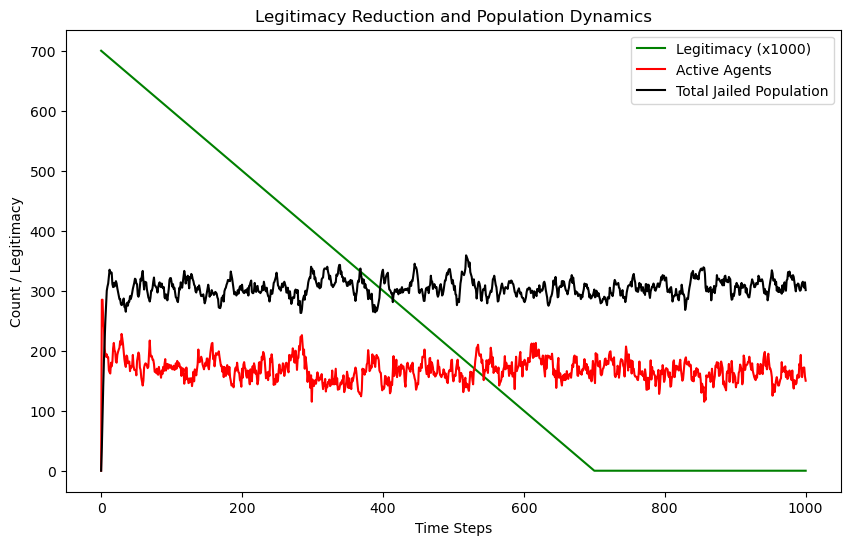

In [53]:
# Figure9&10
model = EpsteinCivilViolence(
    width=40, height=40, citizen_density=0.7, cop_density=0.04,
    citizen_vision=2, cop_vision=2, legitimacy=0.7, max_jail_term=15,
    active_threshold=0.1, arrest_prob_constant=2.3, movement=True, max_iters=1000, legitimacy_mode='gradual', cop_density_mode='constant'
)
for _ in range(1000):
    model.step()

data = model.datacollector.get_model_vars_dataframe()

# plot
plt.figure(figsize=(10, 6))
plt.plot(data['Legitimacy']*1000, label='Legitimacy (x1000)', color='green')
plt.plot(data['Active'], label='Active Agents', color='red')
plt.plot(data['Jailed'], label='Total Jailed Population', color='black')
plt.xlabel('Time Steps')
plt.ylabel('Count / Legitimacy')
plt.title('Legitimacy Reduction and Population Dynamics')
plt.legend()
plt.show()

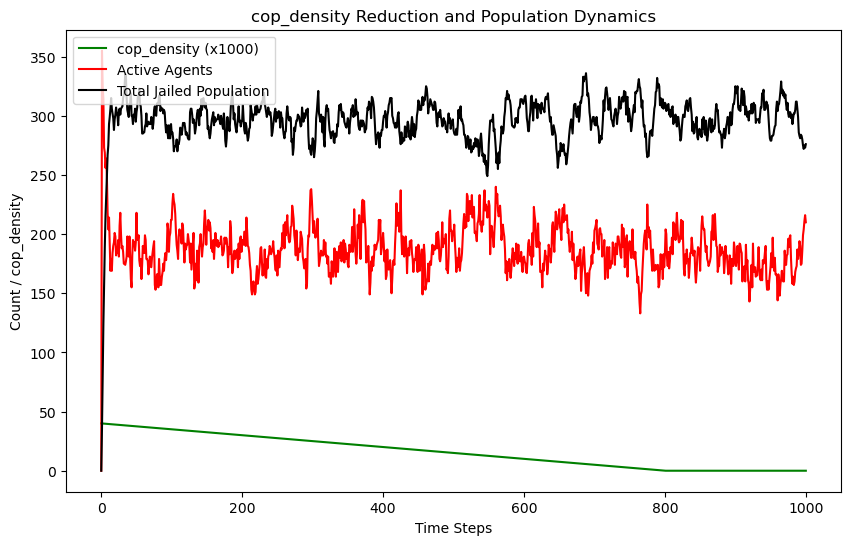

In [61]:
# Figure11
model = EpsteinCivilViolence(
    width=40, height=40, citizen_density=0.7, cop_density=0.04,
    citizen_vision=2, cop_vision=2, legitimacy=0.7, max_jail_term=15,
    active_threshold=0.1, arrest_prob_constant=2.3, movement=True, max_iters=1000, legitimacy_mode='constant', cop_density_mode='gradual'
)
for _ in range(1000):
    model.step()

data = model.datacollector.get_model_vars_dataframe()

# plot
plt.figure(figsize=(10, 6))
plt.plot(data['Cop_Density']*1000, label='cop_density (x1000)', color='green')
plt.plot(data['Active'], label='Active Agents', color='red')
plt.plot(data['Jailed'], label='Total Jailed Population', color='black')
plt.xlabel('Time Steps')
plt.ylabel('Count / cop_density')
plt.title('cop_density Reduction and Population Dynamics')
plt.legend()
plt.show()